In [1]:
#####################################IMPORTANT: SET PATH TO DATA HERE#######################################
###################################It can, but doesn't have to contain data with different deviations. At least one set of data needs to be present: A1-somedev, A2-somedev, A3-somedev, and BASE-somedev
path = "../disk-dynamic-scheduler/output/merged/*.txt"
print(path)

../disk-dynamic-scheduler/output/merged/*.txt


In [2]:
def size_category(size):
    if size <= 200:
        return 'small'
    elif 1000 <= size <= 8000:
        return 'middle'
    elif 10000 <= size <= 18000:
        return 'large'
    elif 20000 <= size <= 30000:
        return 'largest'
    else:
        return 'other'

size_order = ['small', 'middle', 'large', 'largest']
labels = ['A1', 'A2', 'A3', 'BASE']

In [3]:
%run ChartsCommon.ipynb

In [9]:
def plotDynAndStaticVsBase(our_df, deviationsText, titleText, relations):

    #filtered_df = our_df[our_df['relation'].isin(['stat_vs_base', 'dyn_vs_base'])].copy()
    filtered_df = our_df[our_df['relation'].isin(relations)].copy()# ['internal']
    filtered_df['alg_rel'] = filtered_df['algorithm'] + ' - ' + filtered_df['relation']
    #print("filtered_df\n", filtered_df)

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = sns.barplot(
        data=filtered_df,
        x='size',
        y='ratio',
        hue='alg_rel',
        estimator=gmean,
        palette=palette,
        ci=None
    )
    if "internal" in relations:
        baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
    #ax.set_yscale("log")
    plt.xticks(rotation=45)
    #plt.ylim(80000, 200000)

    #plt.tight_layout()
    #plt.ylim(25000, 210000)
    plt.yticks(fontsize=32)
    plt.xticks(fontsize=32)
    plt.xlabel('Workflow size', fontsize=32)
    plt.ylabel('Improvement over the baseline, times', fontsize=32)
    plt.legend(fontsize=32, title_fontsize=32)  


    # Get current tick labels and modify them
    xticks = ax.get_xticks()
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Replace label "100" with "<100"
    new_labels = ["<100" if lbl == "100" else lbl for lbl in xticklabels]

    # Apply the modified labels
    ax.set_xticklabels(new_labels, fontsize=32, rotation=45, ha='right')

    handles, labels = ax.get_legend_handles_labels()

    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]

    
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant", fontsize=24, title_fontsize=26)
   # plt.title(f'{titleText} {deviationsText}', fontsize=28) #Makespan improvement over the baseline,


    #inset_ax = inset_axes(ax, width="40%", height="45%", loc='upper left',
    #                      bbox_to_anchor=(0.1, 0.55, 0.4, 0.4), bbox_transform=fig.transFigure)
    inset_ax = inset_axes(ax,
                          width="35%", height="45%", loc='lower left',
                          bbox_to_anchor=(0.135, 0.12, 0.4, 0.4),  # <-- lower position
                          #(0.135, 0.12, 0.4, 0.4)
                          bbox_transform=fig.transFigure)

    # Filter for small sizes (100 and 200)
    small_df = filtered_df[filtered_df['size'].isin([100, 200])]

    sns.barplot(data=small_df, x='size', y='ratio', hue='alg_rel', ax=inset_ax, estimator=gmean,  palette=palette,ci=None)
    inset_ax.set_yscale("log")  # Show small differences better
    inset_ax.set_title("Zoom on small \n sizes (log scale)", fontsize=24, color='red')
    inset_ax.tick_params(axis='both', labelsize=20)
    inset_ax.set_xlabel("")
    inset_ax.set_ylabel("")
    inset_ax.set_xticklabels([])
    inset_ax.tick_params(axis='y', colors='red')

    for spine in inset_ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)  # Adjust thickness as needed

    # Optionally draw a rectangle to highlight the zoomed region
    # from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    # mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

    # Clean up legend (show only one)
    #ax.legend(title="Algorithm Variant", fontsize=16, title_fontsize=16)
    inset_ax.get_legend().remove()

    #plt.tight_layout()

    plt.savefig(f'improv_ov_baseline_newest_{deviationsText}.png', facecolor='white',  bbox_inches='tight')
    plt.show()
    

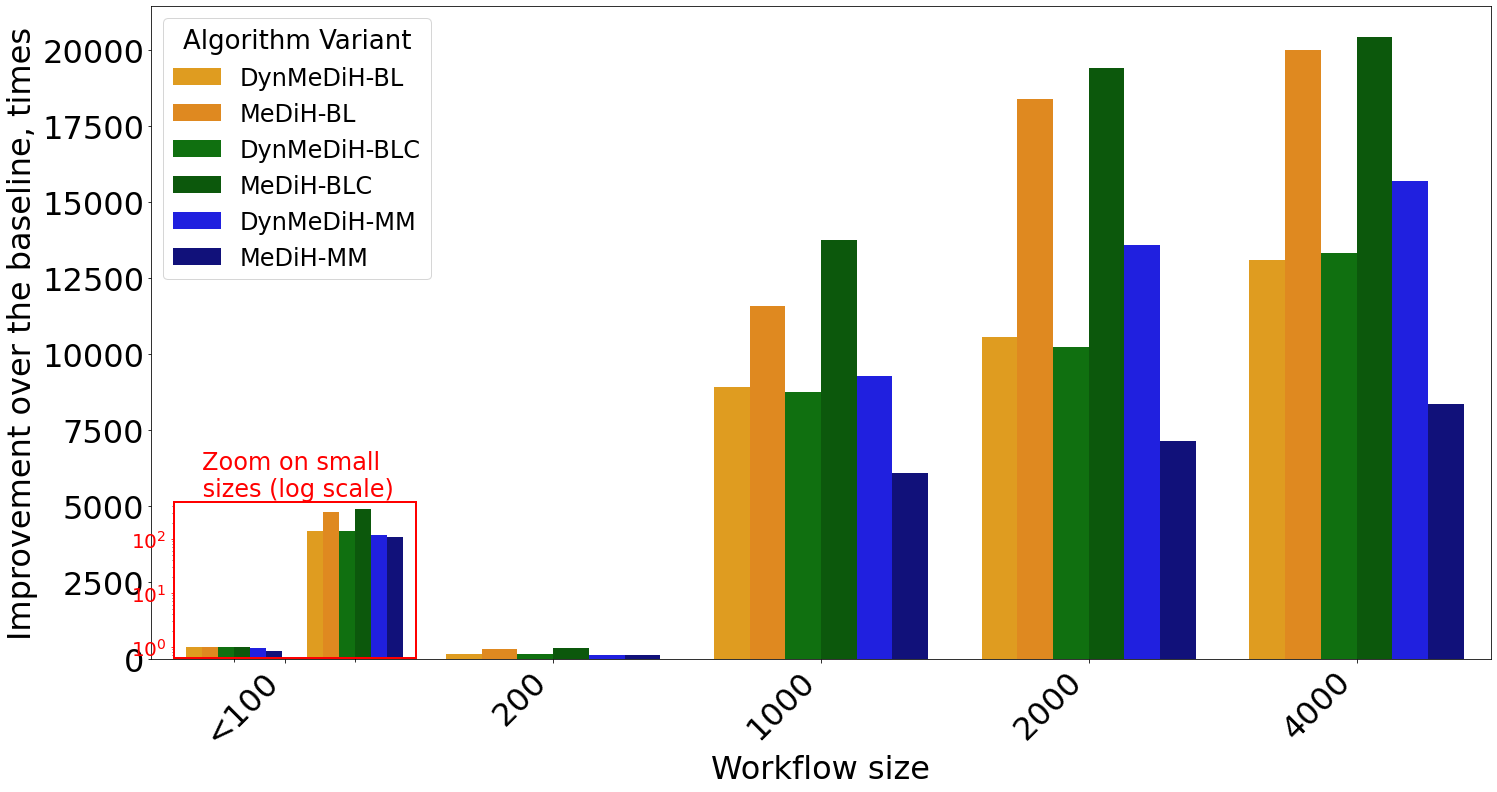

In [11]:
#####################This pattern for deviations, 
#patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

####################This pattern for no deviations
patterndevs = r'^(BASE|A\d+)-(ndev)'

dfs=read_dfs(path,patterndevs, 2)

#######################change deviation text to the desired percentage
dfsVar1 = [dfs[('A1','ndev')], dfs[('A2','ndev')], dfs[('A3','ndev')], dfs[('BASE','ndev')]]
#print(dfsVar1)
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
plot_df = plot_df[plot_df["size"]!= 18000]

plotDynAndStaticVsBase(plot_df, "no deviations", "Makespan improvement over baseline, ", ['stat_vs_base', 'dyn_vs_base'])#



In [12]:
import matplotlib.colors as mcolors
def plotFamiliesByBaseline(plot_df_given, percentage):
    # Filter data
    algosCorrectNames = ['MeDiH-BL', 'MeDiH-BLC', 'MeDiH-MM']
    relations_to_plot = ['stat_vs_base', 'dyn_vs_base']
    internal_df = plot_df_given[
        plot_df_given['relation'].isin(relations_to_plot) & 
        plot_df_given['algorithm'].isin(algosCorrectNames)
    ]
    
    grouped = internal_df.groupby(['relation', 'algorithm', 'family', 'size'], as_index=False).agg({'ratio': gmean})

    # Get unique families and base colors
    families = grouped['family'].unique()
    base_palette = dict(zip(families, sns.color_palette("tab10", n_colors=len(families))))
    
    def adjust_brightness(color, factor):
        #"""Lighten (factor > 1) or darken (factor < 1) an RGB color."""
        c = mcolors.to_rgb(color)
        return tuple(min(max(x * factor, 0), 1) for x in c)

    
    shade_map = {
    'stat_vs_base': 1.0,   # base color (normal)
    'dyn_vs_base': 0.6     # darker version (or use >1.0 for lighter if preferred)
    }


    palette = {}
    for family in families:
        base_color = base_palette[family]
        for algo in algosCorrectNames:
            for relation, shade in shade_map.items():
                shade = shade_map[relation]
                if shade == 1.0:
                    palette[(family, algo, relation)] = base_color
                else:
                    palette[(family, algo, relation)] = adjust_brightness(base_color, factor=shade)

    
    marker_map = {
        'MeDiH-BL': 'o',   # circle
        'MeDiH-BLC': 's',  # square
        'MeDiH-MM': '^'    # diamond
    }
    linestyle_map = {
    'MeDiH-BL': 'dashdot',      # or '-'
    'MeDiH-BLC': 'dashed',    # or '--'
    'MeDiH-MM': 'dotted',     # or ':'
    }


    relation_labels = {'stat_vs_base': 'Static ', 'dyn_vs_base': 'Dyn '}
  

    grouped['label'] = grouped.apply(
    lambda row: f"{row['family']} ({relation_labels[row['relation']]}{row['algorithm']})", axis=1)
    

    ordered_sizes = sorted(grouped['size'].unique())  # numeric order


    plt.figure(figsize=(24, 12))        

    for label, data in grouped.groupby('label'):
        # Parse back
        parts = label.split(' ')
        family = parts[0]
        relation_str = parts[1]
        algo = ' '.join(parts[2:]).strip('()')
        relation = 'dyn_vs_base' if relation_str.startswith('(Dyn') else 'stat_vs_base'
        #print(parts, relation_str, relation, label, "!", algo)
        
        color = palette[(family, algo, relation)]
        label = label.replace("Static ", "")
        label = label.replace("Dyn ", "Dyn")
        
        marker = marker_map[algo]
        lnst = linestyle_map[algo]  # you can keep same linestyle for both stat/dyn if using color difference
        
        
        data = data.sort_values('size')  # <- make sure 100 is first
        #x_values = data['size'].astype(str)  # Equal spacing
        x_values = data['size'].apply(lambda x: ordered_sizes.index(x))  # numeric positions


        #print(label,"!!",data['ratio'], "!!")
        plt.plot(
            x_values, data['ratio'],
            color=color,
            linewidth=2,
            linestyle=lnst,
            label=label,
        )

        plt.scatter(
            x_values, data['ratio'],
            s=120,
            color=color,
            marker=marker,
            edgecolor='black',
            linewidth=0.9,
            zorder=5
        )         
      

    '''plt.figure(figsize=(24, 12))

    sns.barplot(
        data=grouped,
        x='size',
        y='ratio',
        hue='label',
       # palette=palette,  # your custom color mapping
        palette='muted',
        ci=None
    ) '''


    
    plt.xlabel('Workflow size', fontsize=36)
    plt.ylabel('Makespan improvement against baseline', fontsize=36)
    plt.yticks(fontsize=36)
    plt.yscale("log") 
    plt.xticks(
    ticks=range(len(ordered_sizes)),
    labels=[str(s) for s in ordered_sizes],
    fontsize=36
    )
    
    if percentage=="0":
        devtext = "no deviations"
    else:
        devtext = f"devations {percentage}"
   # plt.title(f'Makespan of the dynamic version of the algorithm vs its static counterpart,\n by workflow families, {devtext}', fontsize=36)
   
   # plt.legend(title='Family (Algorithm)', loc='lower right', fontsize=20, title_fontsize=22)
    plt.legend(
    title='Family (Algorithm)',
    loc='lower right',
   # bbox_to_anchor=(0.5, -0.25),  # Move it below the plot
    ncol=3,                       # Two columns
    fontsize=24,
    title_fontsize=30
    #,frameon=False                 # Optional: no legend box border
    )
   
    plt.tight_layout()
    plt.savefig(f"families-{percentage}-vsbaseline.png", dpi=300, bbox_inches='tight')
    plt.show()

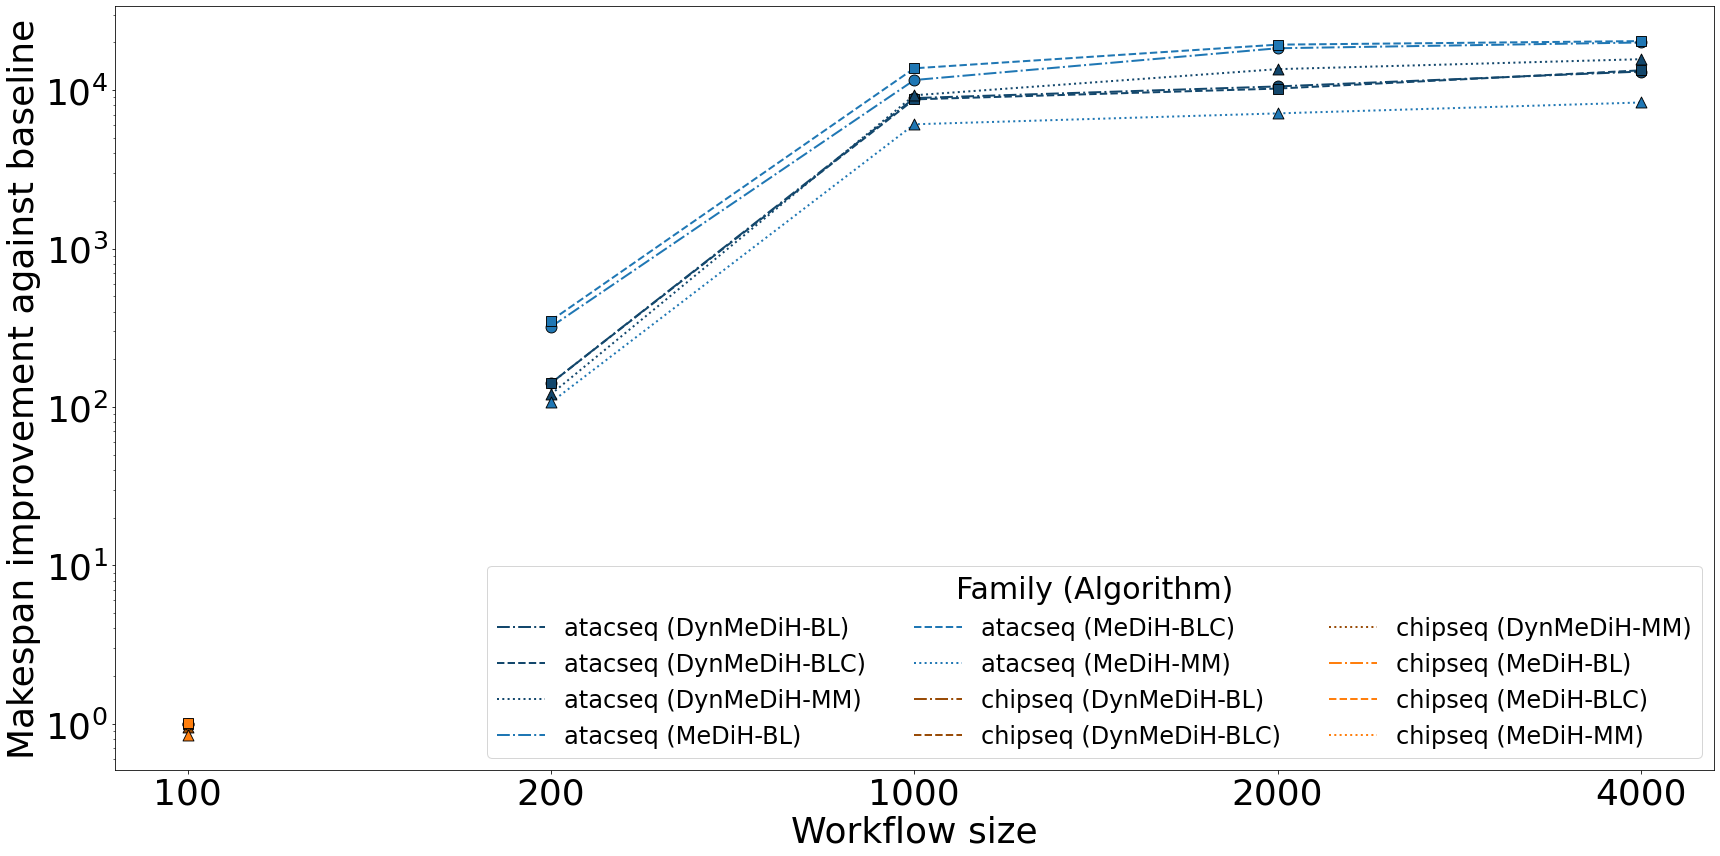

In [13]:

plot_df = buld_plot_df(merged_df_var1)
plot_df["family"]= plot_df['wf_name'].apply(lambda x: x.split('_') [0])
#print(plot_df[plot_df["size"]==200].to_string())
plotFamiliesByBaseline(plot_df, "0")



In [8]:
def merge_runtime_columns(dfsOurVar, lbs):
    renamed_dfs = []
    for df, label in zip(dfsOurVar, lbs):
        # Rename selected columns           
        renamed = df[['wf_name', 'inp_size', 'dur_alg1', 'dur_alg2']].copy()
        renamed = renamed.rename(columns={
            'dur_alg1': f'dur_alg1_{label}',
            'dur_alg2': f'dur_alg2_{label}',
        })            
        renamed_dfs.append(renamed)


    # Merge them all on 'wf_name'
   
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['wf_name', 'inp_size']), renamed_dfs)


    merged_df['size'] = merged_df['wf_name'].str.extract(r'_(\d+)\.')[0].fillna("100")
    merged_df['size'] = merged_df['size'].astype(int)
    
  
    for col in merged_df.columns:       
        if col.startswith("dur_"):
            merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
    
    return merged_df

In [9]:
def buld_plot_df_runtime(merged_df):
    # For storing all ratios in long format
    ratios = []

    for algo in algos:
        df = merged_df.copy()
        df['size'] = df['size']  # group key

        # Compute the 3 relations
        df['internal'] = df[f'dur_alg1_{algo}'] / df[f'dur_alg2_{algo}']
        df['dyn_vs_base'] =  df[f'dur_alg1_{algo}'] / df['dur_alg2_BASE'] 
        df['stat_vs_base'] = df[f'dur_alg2_{algo}'] /df['dur_alg2_BASE']
       

        #print("df in build, before merge ", df)

        # Reshape to long format for seaborn
        melted = df[['size', 'wf_name', 'internal','inp_size', 'dyn_vs_base', 'stat_vs_base']].melt(#
            id_vars=['size', 'wf_name','inp_size'],
            var_name='relation',
            value_name='ratio'
        )
        melted['algorithm'] = algo

        ratios.append(melted)

    # Concatenate all into one DataFrame
    pl_df = pd.concat(ratios, ignore_index=True)

  

    pl_df['algorithm'] = pl_df['algorithm'].replace(algo_aliases)
    return pl_df 

In [10]:
def plotDynAndStaticVsBaseRuntime(our_df, titleText, relations):

    #filtered_df = our_df[our_df['relation'].isin(['stat_vs_base', 'dyn_vs_base'])].copy()
    filtered_df = our_df[our_df['relation'].isin(relations)].copy()# ['internal']
    filtered_df['alg_rel'] = filtered_df['algorithm'] + ' - ' + filtered_df['relation']
    #print("filtered_df\n", filtered_df)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax = sns.barplot(
        data=filtered_df,
        x='size',
        y='ratio',
        hue='alg_rel',
        estimator=gmean,
        palette=palette#,
       # ci=None
    )
    if "internal" in relations:
        baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
    #ax.set_yscale("log")
    plt.xticks(rotation=45)
    #plt.ylim(80000, 200000)

    #plt.tight_layout()
    #plt.ylim(25000, 210000)
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)
    plt.xlabel('Workflow size', fontsize=24)
    plt.ylabel('Runtime compared to the baseline, times', fontsize=24)
    plt.legend(fontsize=20)  


    # Get current tick labels and modify them
    xticks = ax.get_xticks()
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Replace label "100" with "<100"
    new_labels = ["<100" if lbl == "100" else lbl for lbl in xticklabels]

    # Apply the modified labels
    ax.set_xticklabels(new_labels, fontsize=20, rotation=45, ha='right')

    handles, labels = ax.get_legend_handles_labels()

    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]

    
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant", fontsize=24, title_fontsize=26)
   # plt.title(f'Runtimes ', fontsize=28) #Makespan improvement over the baseline,
    plt.savefig("runtimes-relative.png", dpi=300, bbox_inches='tight')
   
    plt.show()

    grouped = filtered_df.groupby(['size', 'alg_rel'])['ratio'].agg(safe_gmean).reset_index()
    # Print the values used for bar heights
    print(grouped)

    gr = grouped.groupby(['alg_rel'])['ratio'].agg(safe_gmean)
    print(gr)

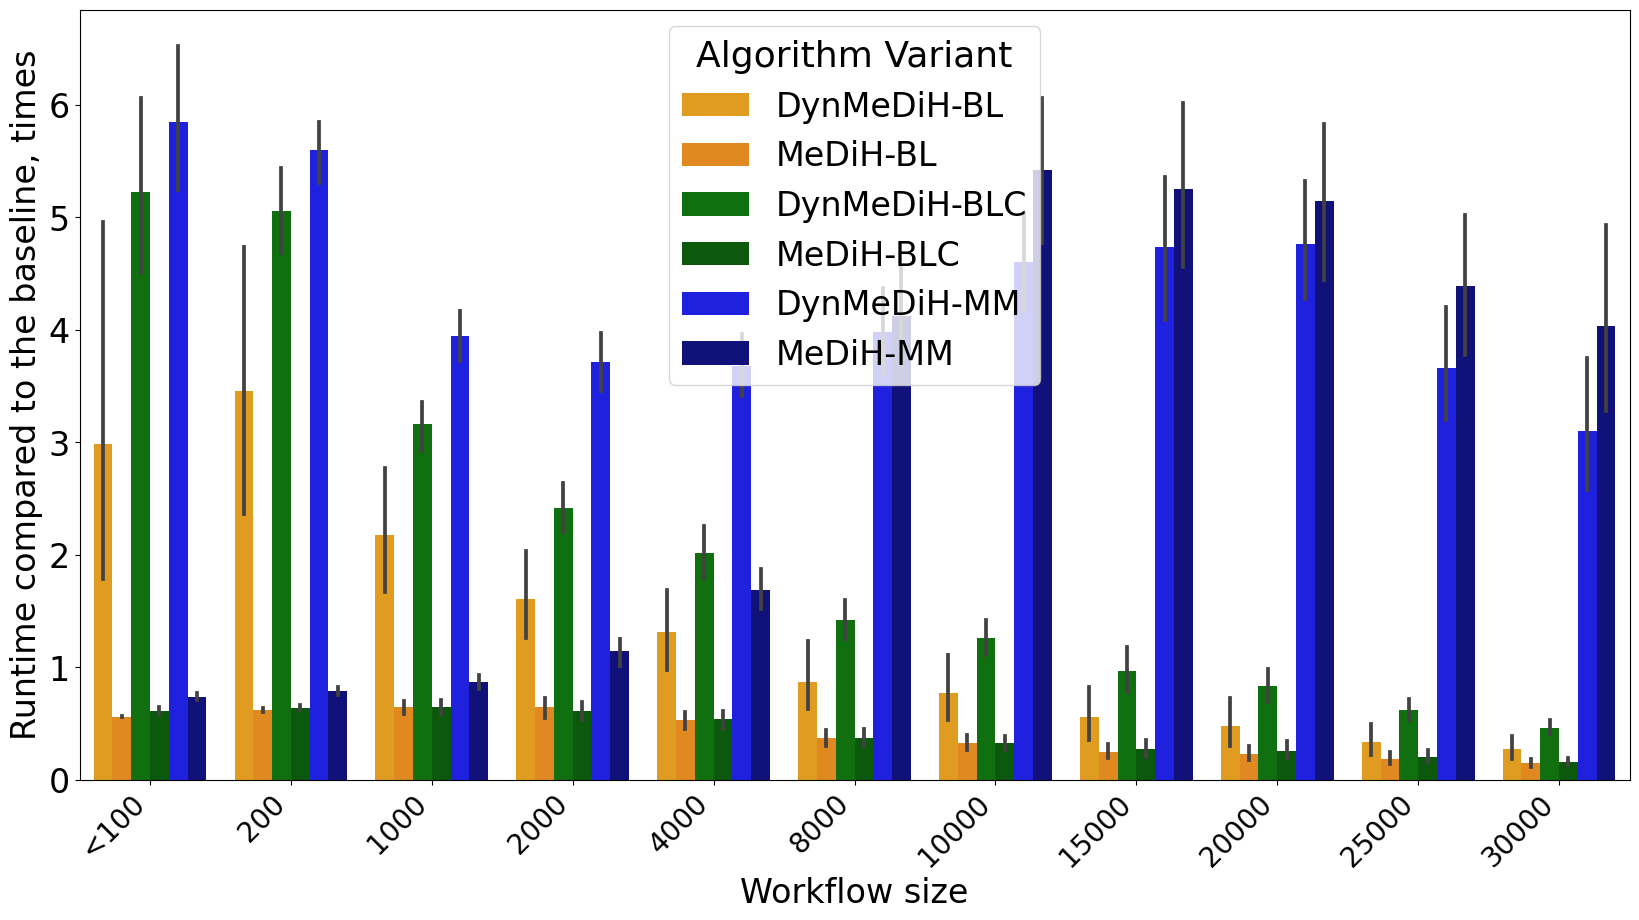

     size                   alg_rel     ratio
0     100    MeDiH-BL - dyn_vs_base  2.981984
1     100   MeDiH-BL - stat_vs_base  0.558956
2     100   MeDiH-BLC - dyn_vs_base  5.227071
3     100  MeDiH-BLC - stat_vs_base  0.613161
4     100    MeDiH-MM - dyn_vs_base  5.849194
..    ...                       ...       ...
61  30000   MeDiH-BL - stat_vs_base  0.145754
62  30000   MeDiH-BLC - dyn_vs_base  0.462496
63  30000  MeDiH-BLC - stat_vs_base  0.159434
64  30000    MeDiH-MM - dyn_vs_base  3.100894
65  30000   MeDiH-MM - stat_vs_base  4.036297

[66 rows x 3 columns]
alg_rel
MeDiH-BL - dyn_vs_base      0.976548
MeDiH-BL - stat_vs_base     0.362426
MeDiH-BLC - dyn_vs_base     1.591073
MeDiH-BLC - stat_vs_base    0.378269
MeDiH-MM - dyn_vs_base      4.253455
MeDiH-MM - stat_vs_base     2.317849
Name: ratio, dtype: float64


In [11]:
merged_df = merge_runtime_columns(dfsVar1, labels)
plot_df = buld_plot_df_runtime(merged_df)
plot_df = plot_df[plot_df["size"]!= 18000]


plotDynAndStaticVsBaseRuntime(plot_df, "title", ['stat_vs_base', 'dyn_vs_base'])